# Initialize

In [1]:
# Imports

import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [2]:
# Get and print the current working directory
current_dir = os.getcwd()
print('Current Working Directory:', current_dir)

# Update and print current working directory
temp_dirpath = os.path.join('D:\\', 'Akshaya')
os.chdir(temp_dirpath)
updated_current_dir = os.getcwd()
print("Updated Current Working Directory:", updated_current_dir)

# Set and print the raw DATA directory
rawDATA_dir = os.path.join(updated_current_dir, 'DATA')
print('Raw DATA Directory:', rawDATA_dir)

# Set and print the Output directory
output_dir = os.path.join(updated_current_dir, 'LULC_dataset', 'jupyterNB_outputs')
print('Output Directory:', output_dir)

Current Working Directory: D:\Akshaya\LULC_dataset
Updated Current Working Directory: D:\Akshaya
Raw DATA Directory: D:\Akshaya\DATA
Output Directory: D:\Akshaya\LULC_dataset\jupyterNB_outputs


In [3]:
# Funtion to create a new folder at specified folder path
def create_folder(folder_path, folder_name):
    try:
        # Join folder path and folder name to create the full path
        full_path = os.path.join(folder_path, folder_name)
        
        # Check if the folder already exists
        if not os.path.exists(full_path):
            # Create the folder
            os.makedirs(full_path)
            print(f"Folder '{folder_name}' created successfully at '{folder_path}'.")
        else:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")     
    return full_path
        
# Create and print Output directory for the current jupyterNB
current_output_dir = create_folder(folder_path=output_dir, folder_name='06_LULC_change')
print('Current jupyterNB Output Directory:', current_output_dir)

Folder '06_LULC_change' already exists at 'D:\Akshaya\LULC_dataset\jupyterNB_outputs'.
Current jupyterNB Output Directory: D:\Akshaya\LULC_dataset\jupyterNB_outputs\06_LULC_change


# Import dataset

In [4]:
# Function to read raster dataset
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        transform = src.transform
    return data, transform

In [5]:
# Image filepaths
image_2019_fpath = os.path.join(output_dir, '03_CNN2019', 'lulc_2019.tif')
image_2023_fpath = os.path.join(output_dir, '04_CNN2023new', 'lulc_2023.tif')

# Load the rasters
data_2019, transform_2019 = load_raster(image_2019_fpath)
data_2023, transform_2023 = load_raster(image_2023_fpath)

In [6]:
print(transform_2019)
print(transform_2023)

| 0.00, 0.00, 77.68|
| 0.00,-0.00, 8.90|
| 0.00, 0.00, 1.00|
| 0.00, 0.00, 77.68|
| 0.00,-0.00, 8.90|
| 0.00, 0.00, 1.00|


# Calculate the area for each class

In [7]:
# Funtion to calculate the area under each class
def calculate_class_area(data, transform):
    unique_classes, counts = np.unique(data, return_counts=True)
    pixel_area = transform[0] * -transform[4]  # Area of one pixel
    class_area = counts * pixel_area
    return dict(zip(unique_classes, class_area))

In [8]:
# Calculate areas for both years
area_2019 = calculate_class_area(data_2019, transform_2019)
area_2023 = calculate_class_area(data_2023, transform_2023)

In [9]:
# Print the area under each class 2019
print('Area under each class 2019:')
for key, val in area_2019.items():
    print (key, '--->', val)
print('\n')

# Print the area under each class 2023
print('Area under each class 2023:')
for key, val in area_2023.items():
    print (key, '--->', val)

Area under each class 2019:
0 ---> 0.022491804959025762
1 ---> 0.06322252780988283
2 ---> 0.015141854456487422
3 ---> 0.0012232863530840603
4 ---> 0.0015977528741508375
5 ---> 0.0501259316349628


Area under each class 2023:
0 ---> 0.011344316548508438
1 ---> 0.08561888431594811
2 ---> 0.003981849935846521
3 ---> 0.004059593459334956
4 ---> 0.004282059045335493
5 ---> 0.04451645478262019


# Reproject the raster Data

In [10]:
# Function to reproject raster image
def reproject_raster(src_path, dst_path, dst_crs):
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [11]:
# Output filepaths
reproj2019_fpath = os.path.join(current_output_dir, '2019_lulc_32644.tif')
reproj2023_fpath = os.path.join(current_output_dir, '2023_lulc_32644.tif')

# Reproject rasters to EPSG:32644
reproject_raster(image_2019_fpath, reproj2019_fpath, 'EPSG:32644')
reproject_raster(image_2023_fpath, reproj2023_fpath, 'EPSG:32644')

In [12]:
# Load the reprojected rasters
data_2019, transform_2019 = load_raster(reproj2019_fpath)
data_2023, transform_2023 = load_raster(reproj2023_fpath)

In [13]:
print(transform_2019)
print(transform_2023)

| 9.91, 0.00, 134776.20|
| 0.00,-9.91, 985080.30|
| 0.00, 0.00, 1.00|
| 9.91, 0.00, 134776.20|
| 0.00,-9.91, 985080.30|
| 0.00, 0.00, 1.00|


# Calculate the area for each class in reprojected image

In [14]:
# Calculate areas for both years
area_2019 = calculate_class_area(data_2019, transform_2019)
area_2023 = calculate_class_area(data_2023, transform_2023)

In [15]:
# Print the area under each class 2019
print('Area under each class 2019:')
for key, val in area_2019.items():
    print (key, '--->', val)
print('\n')

# Print the area under each class 2023
print('Area under each class 2023:')
for key, val in area_2023.items():
    print (key, '--->', val)

Area under each class 2019:
0 ---> 305718610.3779067
1 ---> 770955776.3892598
2 ---> 184710140.2343346
3 ---> 14923165.605983611
4 ---> 19478038.451290317
5 ---> 611390527.8042958


Area under each class 2023:
0 ---> 169736349.6388108
1 ---> 1044127040.3365681
2 ---> 48581214.47699807
3 ---> 49508978.84841564
4 ---> 52224640.90868074
5 ---> 542998034.6535974


In [16]:
# Convert area in m2 to km2
area_2019_sqkm = dict(zip(list(area_2019.keys()), np.array(list(area_2019.values())) / 1000000))
area_2023_sqkm = dict(zip(list(area_2023.keys()), np.array(list(area_2023.values())) / 1000000))

# Print the area under each class 2019
print('Area in sqkm under each class 2019:')
for key, val in area_2019_sqkm.items():
    print (key, '--->', val)
print('\n')

# Print the area under each class 2023
print('Area in sqkm under each class 2023:')
for key, val in area_2023_sqkm.items():
    print (key, '--->', val)

Area in sqkm under each class 2019:
0 ---> 305.71861037790666
1 ---> 770.9557763892598
2 ---> 184.71014023433457
3 ---> 14.92316560598361
4 ---> 19.478038451290317
5 ---> 611.3905278042957


Area in sqkm under each class 2023:
0 ---> 169.73634963881082
1 ---> 1044.1270403365681
2 ---> 48.58121447699807
3 ---> 49.508978848415644
4 ---> 52.22464090868074
5 ---> 542.9980346535973


In [17]:
print(np.round(np.array(list(area_2019_sqkm.values())).sum(),2), np.round_(np.array(list(area_2023_sqkm.values())).sum(),2))

1907.18 1907.18


# Detect Changes and Calculate the Area of Changes

In [18]:
# Function to detect changes
def detect_changes(data1, data2):
    changes = np.where(data1 != data2, data2, -1)
    return changes

# Detect changes
changes = detect_changes(data_2019, data_2023)

In [19]:
def calculate_change_area(changes, transform):
    unique_classes, counts = np.unique(changes, return_counts=True)
    pixel_area = transform[0] * -transform[4]  # Area of one pixel in square meters
    change_area = counts * pixel_area
    return dict(zip(unique_classes, change_area))

# Calculate areas of changes
change_area = calculate_change_area(changes, transform_2019)
print("Change area by class (sq meters):")
for key, val in change_area.items():
    print (key, '--->', val)

Change area by class (sq meters):
-1 ---> 1038304871.6365979
0 ---> 62366841.48306177
1 ---> 458507581.2367319
2 ---> 18585170.91732276
3 ---> 40773563.17754774
4 ---> 36399170.87747548
5 ---> 252239059.53433332


In [20]:
# Convert area in m2 to km2
change_area_sqkm = dict(zip(list(change_area.keys()), np.array(list(change_area.values())) / 1000000))

# Print the area under each class in 'change_area_sqkm'
print('Change area by class (sq km):')
for key, val in change_area_sqkm.items():
    print (key, '--->', val)

Change area by class (sq km):
-1 ---> 1038.304871636598
0 ---> 62.36684148306177
1 ---> 458.5075812367319
2 ---> 18.58517091732276
3 ---> 40.773563177547736
4 ---> 36.39917087747548
5 ---> 252.2390595343333


In [21]:
np.round(np.array(list(change_area_sqkm.values())).sum(), 2)

1907.18

In [22]:
# Function to calculate class-wise changes
def calculate_class_wise_changes(data1, data2, transform):
    unique_classes_1 = np.unique(data1)
    unique_classes_2 = np.unique(data2)
    transition_matrix = np.zeros((len(unique_classes_1), len(unique_classes_2)))

    for i, class_1 in enumerate(unique_classes_1):
        for j, class_2 in enumerate(unique_classes_2):
            change_area = np.sum((data1 == class_1) & (data2 == class_2))
            transition_matrix[i, j] = change_area

    pixel_area_sq_km = (transform[0] * -transform[4]) / 1_000_000  # Convert pixel area to square kilometers
    transition_matrix_area = transition_matrix * pixel_area_sq_km

    return transition_matrix_area, unique_classes_1, unique_classes_2

# Function to calculate percentage changes
def calculate_percentage_changes(transition_matrix_area):
    total_area_2019 = np.sum(transition_matrix_area, axis=1, keepdims=True)
    percentage_changes = (transition_matrix_area / total_area_2019) * 100
    return percentage_changes

In [23]:
# Calculate class-wise changes
transition_matrix_area, unique_classes_2019, unique_classes_2023 = calculate_class_wise_changes(data_2019, data_2023, transform_2019)

In [24]:
# Calculate percentage changes
percentage_changes = calculate_percentage_changes(transition_matrix_area)

In [25]:
# Display results
for i, class_2019 in enumerate(unique_classes_2019):
    for j, class_2023 in enumerate(unique_classes_2023):
        area_change = transition_matrix_area[i, j]
        percentage_change = percentage_changes[i, j]
        if area_change > 0:
            print(f"Class {class_2019} changed to Class {class_2023}: {area_change:.2f} sq km ({percentage_change:.2f}%)")

Class 0 changed to Class 0: 107.37 sq km (35.12%)
Class 0 changed to Class 1: 131.66 sq km (43.06%)
Class 0 changed to Class 2: 2.09 sq km (0.69%)
Class 0 changed to Class 3: 6.46 sq km (2.11%)
Class 0 changed to Class 4: 12.86 sq km (4.21%)
Class 0 changed to Class 5: 45.28 sq km (14.81%)
Class 1 changed to Class 0: 36.04 sq km (4.67%)
Class 1 changed to Class 1: 585.62 sq km (75.96%)
Class 1 changed to Class 2: 2.33 sq km (0.30%)
Class 1 changed to Class 3: 14.08 sq km (1.83%)
Class 1 changed to Class 4: 11.35 sq km (1.47%)
Class 1 changed to Class 5: 121.54 sq km (15.76%)
Class 2 changed to Class 0: 5.56 sq km (3.01%)
Class 2 changed to Class 1: 53.89 sq km (29.18%)
Class 2 changed to Class 2: 30.00 sq km (16.24%)
Class 2 changed to Class 3: 8.68 sq km (4.70%)
Class 2 changed to Class 4: 1.35 sq km (0.73%)
Class 2 changed to Class 5: 85.23 sq km (46.14%)
Class 3 changed to Class 0: 0.01 sq km (0.08%)
Class 3 changed to Class 1: 0.24 sq km (1.59%)
Class 3 changed to Class 2: 0.00 sq 

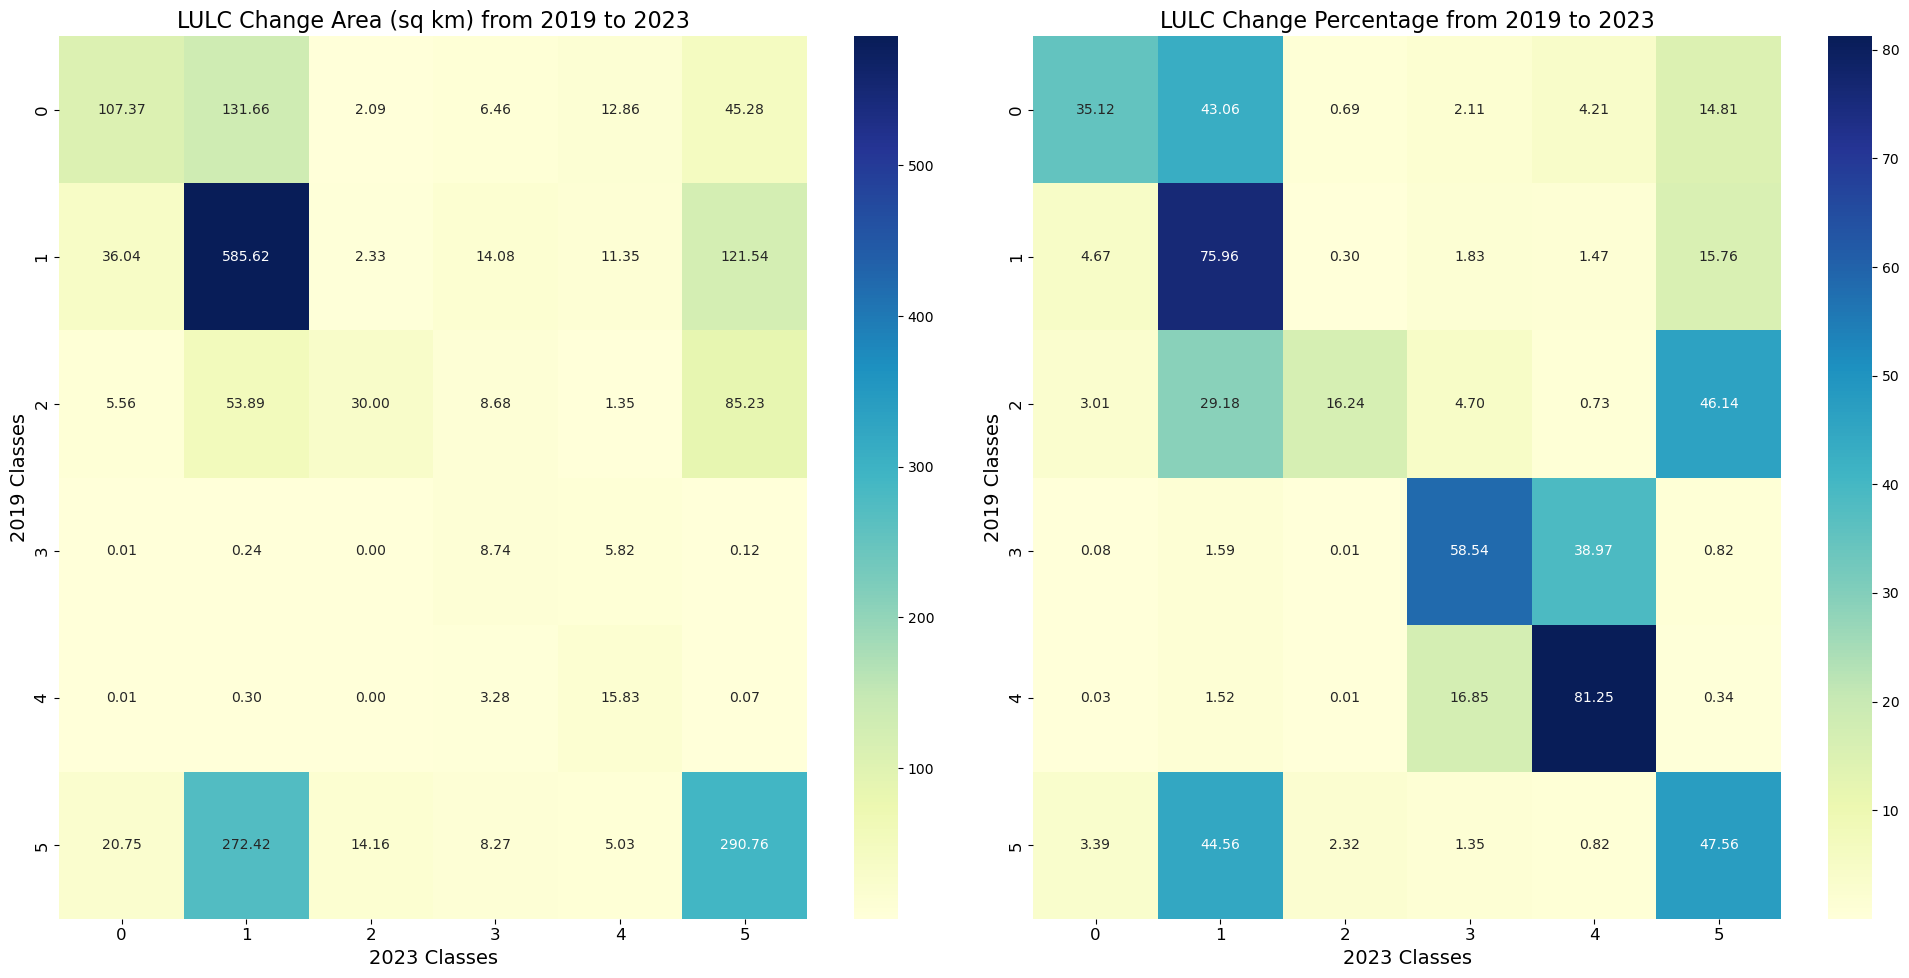

In [26]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for area changes
sns.heatmap(transition_matrix_area, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=unique_classes_2023, yticklabels=unique_classes_2019, ax=axs[0])
axs[0].set_title("LULC Change Area (sq km) from 2019 to 2023")
axs[0].set_xlabel("2023 Classes")
axs[0].set_ylabel("2019 Classes")

# Heatmap for percentage changes
sns.heatmap(percentage_changes, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=unique_classes_2023, yticklabels=unique_classes_2019, ax=axs[1])
axs[1].set_title("LULC Change Percentage from 2019 to 2023")
axs[1].set_xlabel("2023 Classes")
axs[1].set_ylabel("2019 Classes")


# Set global font size
plt.rcParams.update({'font.size': 14})  # Adjust the base font size as needed

# Increase font size for specific elements if needed
axs[0].set_title("LULC Change Area (sq km) from 2019 to 2023", fontsize=16)
axs[0].set_xlabel("2023 Classes", fontsize=14)
axs[0].set_ylabel("2019 Classes", fontsize=14)

axs[1].set_title("LULC Change Percentage from 2019 to 2023", fontsize=16)
axs[1].set_xlabel("2023 Classes", fontsize=14)
axs[1].set_ylabel("2019 Classes", fontsize=14)

# Adjust font size for ticks and labels
for ax in axs.flat:
    ax.tick_params(labelsize=12)

plt.tight_layout()
# Save the figure
plt.savefig(os.path.join(current_output_dir, 'LULC_Change_Analysis.png'), dpi=300)  # Save as PNG with 300 dpi
# plt.savefig('LULC_Change_Analysis.pdf')  # Save as PDF
plt.show()

In [27]:
CLASSES = [0, 1, 2, 3, 4, 5]
CLASS_NAME = ['Built Up', 'Agricultural land', 'Wastelands', 'Water bodies', 'Wetlands', 'Forest']
classNames_dict = dict(zip(CLASSES, CLASS_NAME))
classNames_dict

{0: 'Built Up',
 1: 'Agricultural land',
 2: 'Wastelands',
 3: 'Water bodies',
 4: 'Wetlands',
 5: 'Forest'}

In [28]:
result_df = pd.concat([pd.Series(classNames_dict), pd.Series(area_2019_sqkm), pd.Series(area_2023_sqkm)], axis=1)
result_df.columns = ['LC_TYPE', 'AREA_2019_sqkm', 'AREA_2023_sqkm']
result_df.head()

,LC_TYPE,AREA_2019_sqkm,AREA_2023_sqkm
0,Built Up,305.718610,169.736350
1,Agricultural land,770.955776,1044.127040
2,Wastelands,184.710140,48.581214
3,Water bodies,14.923166,49.508979
4,Wetlands,19.478038,52.224641


# Carbon sequestration or emission

In [29]:
# Define Carbon Sequestration/Emission Factors ftom IPCC - 2006
carbon_factors = {0: 0,  # Example: Emission source, e.g., Built Up
                  1: 1.1,    # Example: Agricultural land
                  2: 0,    # Example: Wastelands
                  3: 0,    # Example: Water bodies
                  4: 0.04,    # Example: Wetlands
                  5: 0.47,    # Example: Forest land
                 }

In [30]:
# Calculate Carbon Sequestration or Emission
def calculate_carbon_emission(area, carbon_factors):
    carbon_emission = {}
    for lulc_class, area_sq_km in area.items():
        area_ha = area_sq_km * 100  # Convert sq km to hectares
        carbon_emission_tons = area_ha * carbon_factors.get(lulc_class, 0)
        carbon_emission[lulc_class] = carbon_emission_tons
    return carbon_emission

In [31]:
ce_2019 = calculate_carbon_emission(area_2019, carbon_factors)
ce_2023 = calculate_carbon_emission(area_2023, carbon_factors)

# Print the carbon_emission under each class in 2019
print('2019 Carbon sequestration or emission by class (tons CO2/year):')
for key, val in ce_2019.items():
    print (key, '--->', val)
# Print the carbon_emission under each class in 2023
print('2023 Carbon sequestration or emission by class (tons CO2/year)')
for key, val in ce_2023.items():
    print (key, '--->', val)

2019 Carbon sequestration or emission by class (tons CO2/year):
0 ---> 0.0
1 ---> 84805135402.81859
2 ---> 0.0
3 ---> 0.0
4 ---> 77912153.80516127
5 ---> 28735354806.801903
2023 Carbon sequestration or emission by class (tons CO2/year)
0 ---> 0.0
1 ---> 114853974437.0225
2 ---> 0.0
3 ---> 0.0
4 ---> 208898563.63472295
5 ---> 25520907628.719074


In [32]:
ce_result = pd.concat([pd.Series(ce_2019), pd.Series(ce_2023)], axis=1)
ce_result.columns = ['ce_2019', 'ce_2023']
ce_result.head()

,ce_2019,ce_2023
0,0.000000e+00,0.000000e+00
1,8.480514e+10,1.148540e+11
2,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00
4,7.791215e+07,2.088986e+08


In [33]:
result_df = pd.concat([result_df, ce_result], axis=1)
result_df['ce_change'] = result_df['ce_2023'] - result_df['ce_2019']
result_df['percentage_change'] = (result_df['ce_change'] / result_df['ce_2019']) * 100
result_df.head()

,LC_TYPE,AREA_2019_sqkm,AREA_2023_sqkm,ce_2019,ce_2023,ce_change,percentage_change
0,Built Up,305.718610,169.736350,0.000000e+00,0.000000e+00,0.000000e+00,NaN
1,Agricultural land,770.955776,1044.127040,8.480514e+10,1.148540e+11,3.004884e+10,35.432806
2,Wastelands,184.710140,48.581214,0.000000e+00,0.000000e+00,0.000000e+00,NaN
3,Water bodies,14.923166,49.508979,0.000000e+00,0.000000e+00,0.000000e+00,NaN
4,Wetlands,19.478038,52.224641,7.791215e+07,2.088986e+08,1.309864e+08,168.120638


# Export dataset

In [34]:
# Save the prediction as a GeoTIFF using properties from an existing satellite image
# Load the existing satellite image
with rasterio.open(image_2019_fpath) as src:
    # Copy metadata
    meta = src.meta.copy()
    meta.update({
        'dtype': 'int32',  # Assuming the prediction values are integer
        'count': 1
    })

    # Save the prediction array as a GeoTIFF
    with rasterio.open(os.path.join(current_output_dir, 'LULC_change.tif'), 'w', **meta) as dst:
        dst.write(changes.astype(rasterio.int32), 1)

In [35]:
result_df.to_csv(os.path.join(current_output_dir, 'result_df.csv'), index=False)

In [36]:
classNames_dict

{0: 'Built Up',
 1: 'Agricultural land',
 2: 'Wastelands',
 3: 'Water bodies',
 4: 'Wetlands',
 5: 'Forest'}

In [37]:
# classNames_dict[-1] = 'NO_CHANGE'
pd.Series(classNames_dict, name='LC_TYPE').sort_index()

0             Built Up
1    Agricultural land
2           Wastelands
3         Water bodies
4             Wetlands
5               Forest
Name: LC_TYPE, dtype: object

In [38]:
area_change = pd.concat([pd.DataFrame(pd.Series(change_area_sqkm, name='AREA_CHANGED_sqkm')), 
                         pd.Series(classNames_dict, name='LC_TYPE').sort_index()], axis=1).reset_index(drop=True)
area_change

,AREA_CHANGED_sqkm,LC_TYPE
0,1038.304872,NaN
1,62.366841,Built Up
2,458.507581,Agricultural land
3,18.585171,Wastelands
4,40.773563,Water bodies
5,36.399171,Wetlands
6,252.239060,Forest


In [39]:
area_change.to_csv(os.path.join(current_output_dir, 'area_change.csv'), index=False)